<a href="https://colab.research.google.com/github/amaluvincent/Fake-News-Detection/blob/main/data_processing_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Setting up the environment

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk
!pip install tensorflow keras


# 2.Importing libraraies

In [ ]:
# import necessary libabaries
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection
from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 3.Load dataset

In [ ]:
# Load the ISOT dataset
true_news = pd.read_csv('/content/True.csv')
fake_news =  pd.read_csv('/content/Fake.csv')

# checking the size of each files
print('true:',true_news.shape)
print('fake:', fake_news.shape)


true: (21417, 4)
fake: (23481, 4)


# 4. Data cleaning and preparation

In [ ]:
# Add a label to each dataframe
true_news['label'] = 0   # 0 for legitimate news
fake_news['label'] = 1   # 1 for fake news

# Combine both datasets
df = pd.concat([true_news, fake_news],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # shuffle the data

# Print the combined dataset (first few rows)
print(df.head(5))
print(df.shape)



                                               title  \
0  Swiss to represent Iran, Saudi interests after...   
1  'Get off of Twitter': As Trump nears Day 100, ...   
2  Yemen cholera cases could hit 1 million by yea...   
3  WHOA! DEMOCRATIC Strategist Gives Crooked Hill...   
4  South Sudan rebels say army attacked them afte...   

                                                text       subject  \
0  ZURICH (Reuters) - Neutral Switzerland s embas...     worldnews   
1   CLEARWATER, Fla. (Reuters) - Some of his supp...  politicsNews   
2  GENEVA (Reuters) - The humanitarian situation ...     worldnews   
3  The most unpopular, deplorable woman in Americ...     left-news   
4  JUBA (Reuters) - A South Sudanese rebel group ...     worldnews   

                  date  label  
0    October 25, 2017       0  
1      April 28, 2017       0  
2  September 29, 2017       0  
3          Oct 2, 2016      1  
4   December 22, 2017       0  
(44898, 5)


In [ ]:
# print dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [ ]:
# Removing unnecessary column(date)
df = df.drop(columns=["date"])
print(df.head())

                                               title  \
0  Swiss to represent Iran, Saudi interests after...   
1  'Get off of Twitter': As Trump nears Day 100, ...   
2  Yemen cholera cases could hit 1 million by yea...   
3  WHOA! DEMOCRATIC Strategist Gives Crooked Hill...   
4  South Sudan rebels say army attacked them afte...   

                                                text       subject  label  
0  ZURICH (Reuters) - Neutral Switzerland s embas...     worldnews      0  
1   CLEARWATER, Fla. (Reuters) - Some of his supp...  politicsNews      0  
2  GENEVA (Reuters) - The humanitarian situation ...     worldnews      0  
3  The most unpopular, deplorable woman in Americ...     left-news      1  
4  JUBA (Reuters) - A South Sudanese rebel group ...     worldnews      0  


In [ ]:
df = df.drop(columns=["title"])
print(df.head())

                                                text       subject  label
0  ZURICH (Reuters) - Neutral Switzerland s embas...     worldnews      0
1   CLEARWATER, Fla. (Reuters) - Some of his supp...  politicsNews      0
2  GENEVA (Reuters) - The humanitarian situation ...     worldnews      0
3  The most unpopular, deplorable woman in Americ...     left-news      1
4  JUBA (Reuters) - A South Sudanese rebel group ...     worldnews      0


In [ ]:
# convert to lowercase
df['text'] = df['text'].str.lower()

# Verify by printing the first few rows of the updated dataframe
print(df[[ 'text']].head())

                                                text
0  zurich (reuters) - neutral switzerland s embas...
1   clearwater, fla. (reuters) - some of his supp...
2  geneva (reuters) - the humanitarian situation ...
3  the most unpopular, deplorable woman in americ...
4  juba (reuters) - a south sudanese rebel group ...


In [ ]:
# Remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].apply(remove_punctuation)

# Verify by printing the first few rows of the updated dataframe
print(df.head())


                                                text       subject  label
0  zurich reuters  neutral switzerland s embassie...     worldnews      0
1   clearwater fla reuters  some of his supporter...  politicsNews      0
2  geneva reuters  the humanitarian situation in ...     worldnews      0
3  the most unpopular deplorable woman in america...     left-news      1
4  juba reuters  a south sudanese rebel group on ...     worldnews      0


In [ ]:
# Set the stopwords for the English language
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords
def remove_stopwords(text):
    # Tokenize the text into words
    words = text.split()
    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Join the filtered words back into a single string
    return ' '.join(filtered_words)

# Apply the function to the 'text' colum
df['text'] = df['text'].apply(remove_stopwords)

# Verify by printing the first few rows of the updated dataframe
print(df[['text']].head())


                                                text
0  zurich reuters neutral switzerland embassies r...
1  clearwater fla reuters supporters fret preside...
2  geneva reuters humanitarian situation yemen ca...
3  unpopular deplorable woman america champion wa...
4  juba reuters south sudanese rebel group friday...


# 5.Exploratory Data Analysis

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


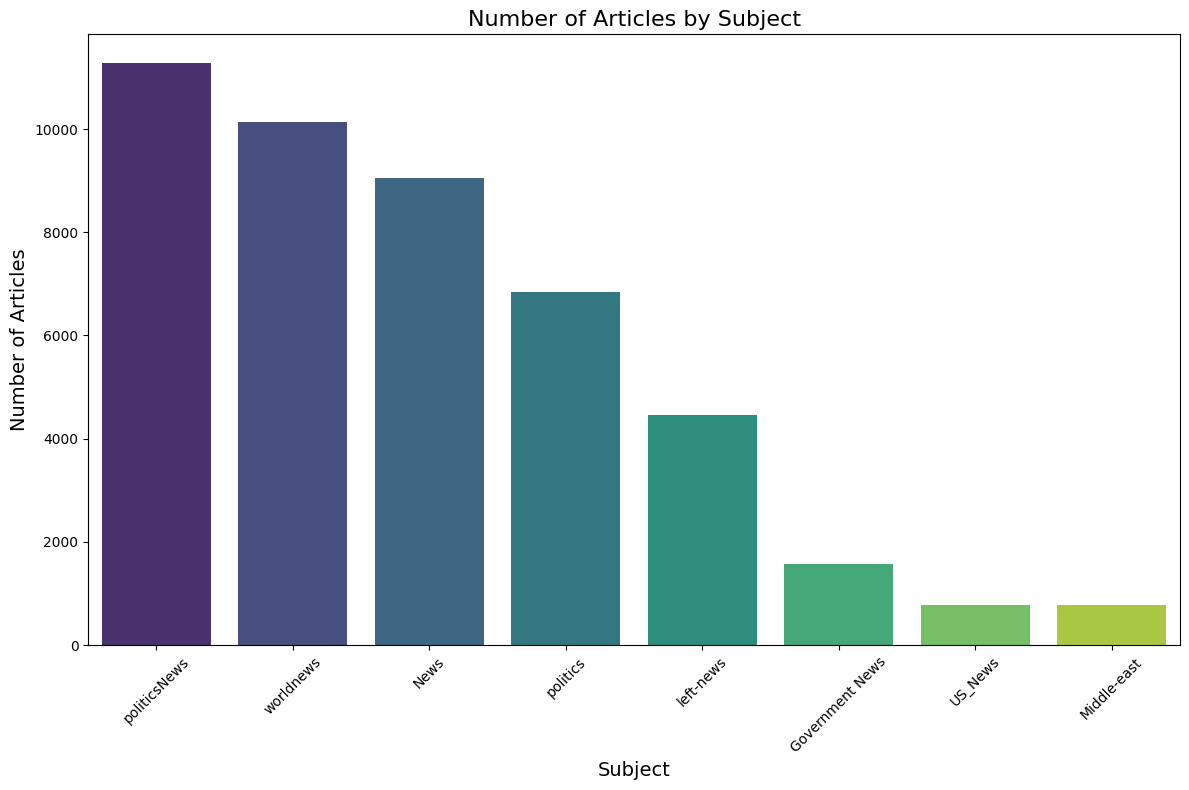

In [ ]:
# Count the number of articles by subject
subject_counts = df['subject'].value_counts()
print(subject_counts)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=subject_counts.index, y=subject_counts.values, palette='viridis')
plt.title('Number of Articles by Subject', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


label
1    23481
0    21417
Name: count, dtype: int64


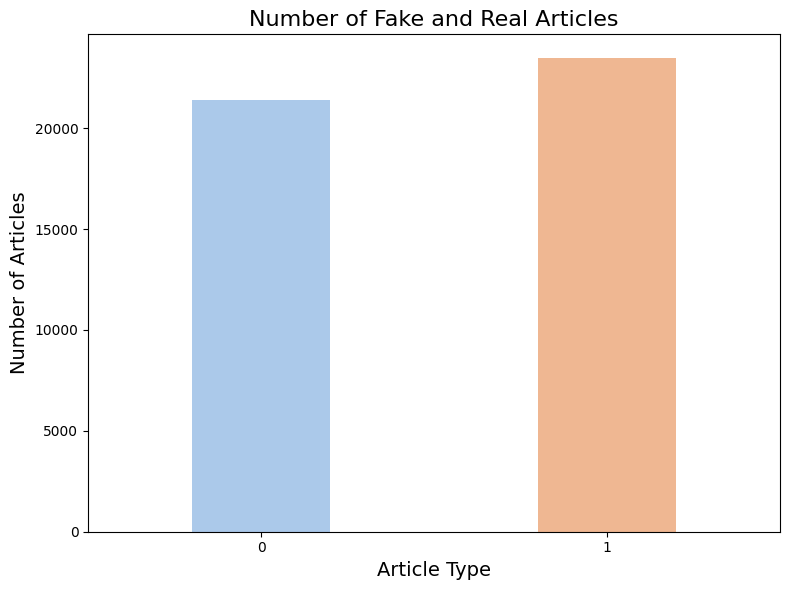

In [ ]:
# How many fake and real articles?
article_counts = df['label'].value_counts()
print(article_counts)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=article_counts.index, y=article_counts.values, palette='pastel', width=0.4)
plt.title('Number of Fake and Real Articles', fontsize=16)
plt.xlabel('Article Type', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


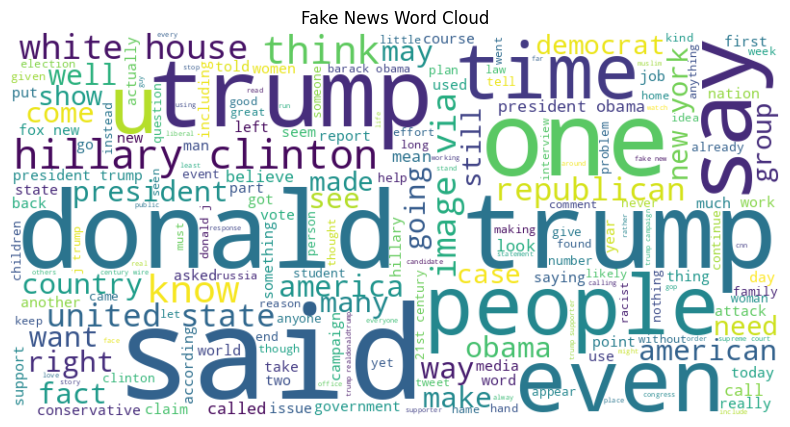

In [ ]:
# Word cloud for fake news
fake_words = ' '.join(df[df['label'] == 1]['text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')
plt.show()

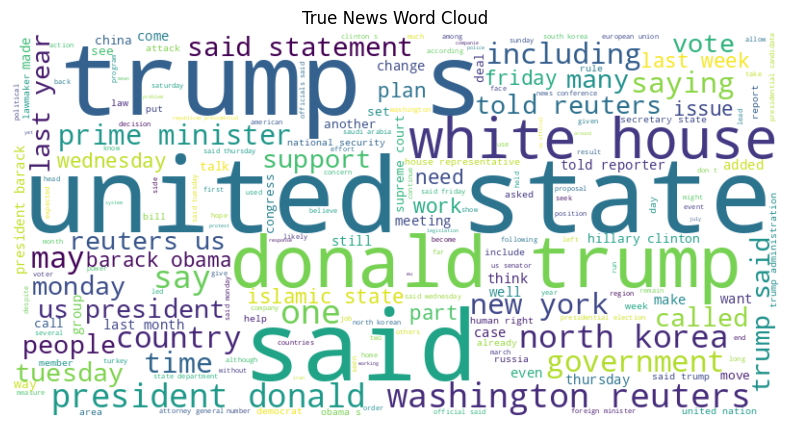

In [ ]:
# Word cloud for true news

true_words = ' '.join(df[df['label'] == 0]['text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('True News Word Cloud')
plt.show()

Top 20 words in Fake News: [('trump', 73422), ('said', 31008), ('people', 25941), ('president', 25495), ('would', 23420), ('one', 22865), ('us', 22005), ('clinton', 17957), ('obama', 17760), ('like', 17596), ('donald', 17101), ('also', 15221), ('new', 14135), ('news', 14099), ('even', 13658), ('hillary', 13510), ('white', 12767), ('time', 12689), ('state', 12494), ('via', 11164)]
Top 20 words in Real News: [('said', 99017), ('trump', 42061), ('us', 40847), ('would', 31418), ('reuters', 28306), ('president', 25223), ('state', 18547), ('government', 17851), ('new', 16712), ('house', 16294), ('states', 16063), ('also', 15935), ('united', 15566), ('republican', 15273), ('people', 14604), ('told', 14243), ('could', 13650), ('last', 12579), ('one', 12295), ('washington', 12088)]


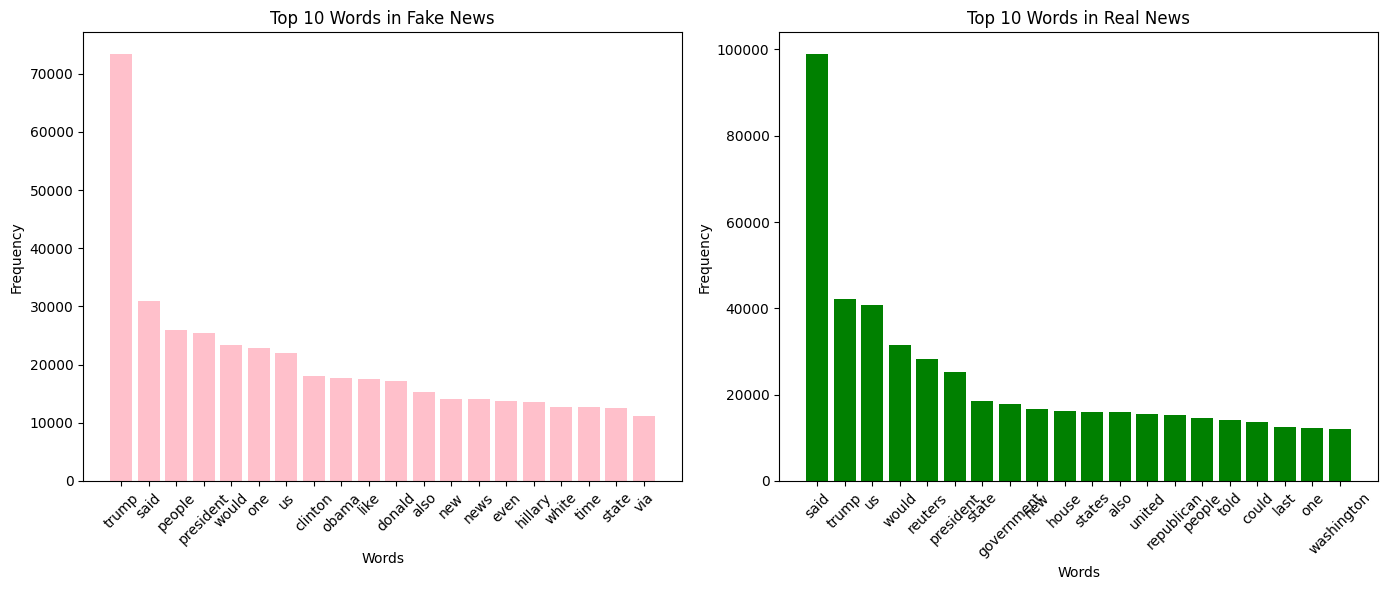

In [ ]:
# Most  frequent words counter
# Fake News Word Frequency
fake_words = ' '.join(df[df['label'] == 1]['text']).split()
counter_fake = Counter(fake_words)
top_fake = counter_fake.most_common(20)
print("Top 20 words in Fake News:", counter_fake.most_common(20))

# Real News Word Frequency
real_words = ' '.join(df[df['label'] == 0]['text']).split()
counter_real = Counter(real_words)
top_real = counter_real.most_common(20)
print("Top 20 words in Real News:", counter_real.most_common(20))

# Unpack the top words and their counts for fake and real news
fake_words_list, fake_counts = zip(*top_fake)
real_words_list, real_counts = zip(*top_real)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fake News Plot
axes[0].bar(fake_words_list, fake_counts, color='pink')
axes[0].set_title('Top 10 Words in Fake News')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(fake_words_list, rotation=45)

# Real News Plot
axes[1].bar(real_words_list, real_counts, color='green')
axes[1].set_title('Top 10 Words in Real News')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(real_words_list, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# 6.Training & Testing Data

In [ ]:
# Train-test split
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

# Check the shapes of the splits
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
print(X_train)
print(y_train)

Training set size: 35918, Test set size: 8980
36335    astana reuters turkey iran agreed discuss with...
12384    right arms sally yates threw huge snowball ava...
24419    last night official white house correspondents...
24740    tweet president trump mentioned spoke south ko...
27039    paris reuters french island martinique escaped...
                               ...                        
11284    economic devastation real west virginia obama ...
44732    rep frederica wilson spoke thursday annual leg...
38158    moscow reuters kremlin spokesman dmitry peskov...
860      donald trump efforts reach voters color going ...
15795    infowars uncovered bombshell discovered facebo...
Name: text, Length: 35918, dtype: object
36335    0
12384    1
24419    1
24740    1
27039    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: label, Length: 35918, dtype: int64


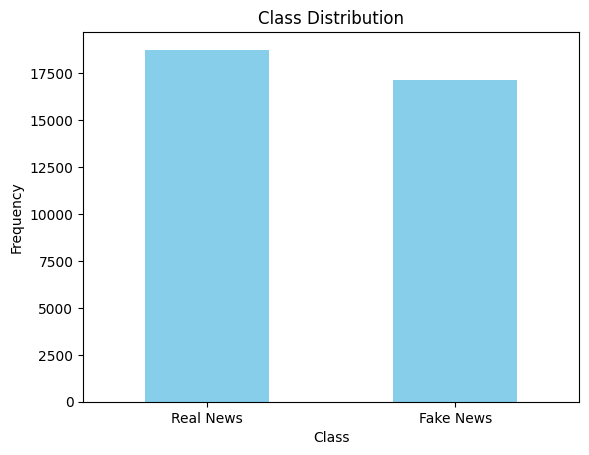

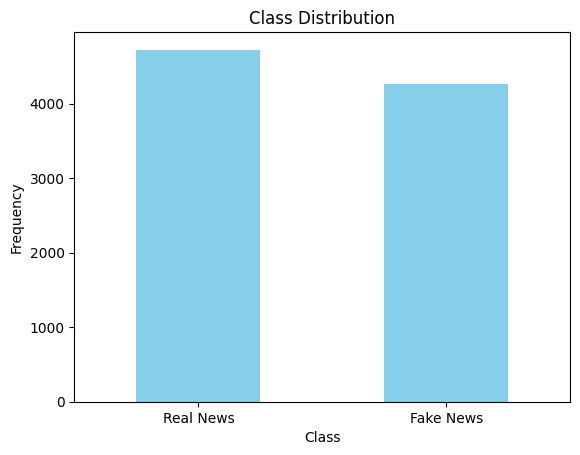

In [ ]:
#. Evaluate Class Distribution
#Check the distribution of your classes in the training and test sets:


# Plot class distribution
def plot_class_distribution(y):
    y.value_counts().plot(kind='bar', color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(ticks=[0, 1], labels=['Real News', 'Fake News'], rotation=0)
    plt.show()

# Plot for training set
plot_class_distribution(y_train)

# Plot for test set
plot_class_distribution(y_test)


# 7. Model Creation

In [ ]:
# Define the three models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)  # SVM with linear kernel
}

# Function to train, evaluate and compare models
def evaluate_models(X_train, y_train, X_test, y_test):
    for model_name, model in models.items():
        # Create a pipeline for each model
        pipe = Pipeline([
            ('vect', CountVectorizer()),     # Vectorizer
            ('tfidf', TfidfTransformer()),   # Apply TF-IDF
            ('clf', model)                   # Classifier (Logistic Regression, Random Forest, or SVM)
        ])
        # Train the model
        pipe.fit(X_train, y_train)

        # Predict on test data
        y_pred = pipe.predict(X_test)

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")

        # Calculate precision, recall, and F1-score
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"{model_name} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

        # Classification report
        print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))


Logistic Regression Accuracy: 98.84%
Logistic Regression - Precision: 0.99, Recall: 0.99, F1 Score: 0.99


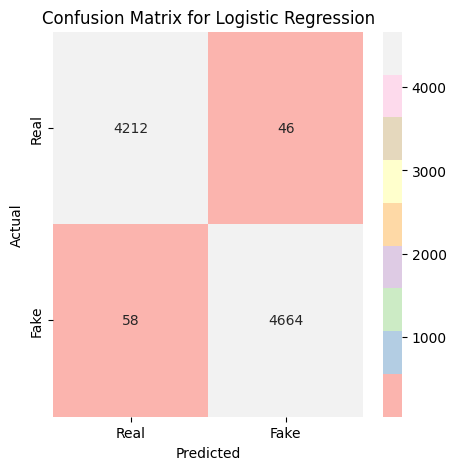

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4258
           1       0.99      0.99      0.99      4722

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Random Forest Accuracy: 99.16%
Random Forest - Precision: 1.00, Recall: 0.99, F1 Score: 0.99


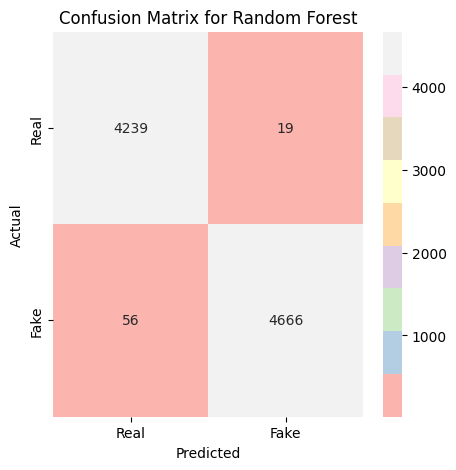

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4258
           1       1.00      0.99      0.99      4722

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

SVM Accuracy: 99.54%
SVM - Precision: 1.00, Recall: 0.99, F1 Score: 1.00


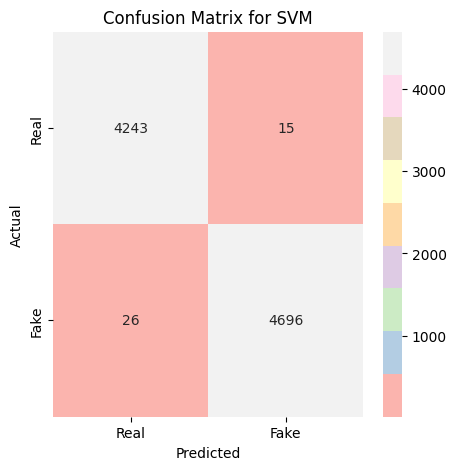

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4258
           1       1.00      0.99      1.00      4722

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
# Call the evaluation function
evaluate_models(X_train, y_train, X_test, y_test)

In [ ]:
# Cross-validation to compare model stability
for model_name, model in models.items():
    pipe = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validated scores for {model_name}: {cv_scores}")
    print(f"Mean cross-validated accuracy for {model_name}: {cv_scores.mean() * 100:.2f}%")

Cross-validated scores for Logistic Regression: [0.9889755  0.98919822 0.98797327 0.98930839 0.98908564]
Mean cross-validated accuracy for Logistic Regression: 98.89%
Cross-validated scores for Random Forest: [0.9922049  0.99309577 0.99120267 0.99164718 0.99131306]
Mean cross-validated accuracy for Random Forest: 99.19%


# Feature Important Analysis

In [ ]:
# Get feature importance from the Decision Tree model
feature_importances = best_model.named_steps['model'].feature_importances_

# Get feature names from the CountVectorizer step
feature_names = best_model.named_steps['vect'].get_feature_names_out()

# Top 10 important features
important_features = sorted(zip(feature_importances, feature_names), reverse=True)[:10]
print("Top 10 important features:", important_features)
